In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.pseudotime_common import do_pca_pt, spearman_rho_pools

from jtb_2022_code.figure_3 import figure_3_plot
from jtb_2022_code.figure_3_supplemental import figure_3_supplement_1_plot

from jtb_2022_code import FigureSingleCellData
from jtb_2022_code.figure_constants import RAPA_TIME_COL, CC_TIME_COL

import gc
import numpy as np

import inferelator_velocity as ifv

In [3]:
data = FigureSingleCellData()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [4]:
## LOAD AND PROCESS UMAP FOR PCA AND PT PANELS ###
#data = FigureSingleCellData()
data.do_projections()
data.apply_inplace_to_everything(do_pca_pt)

if 'DEWAKSS_pca' not in data.expt_data[(1, "WT")].obsm:
    for k in data.expts:
        _denoised = do_pca_pt(
            data.denoised_data(*k), 
            pt_key="denoised_pca_pt"
        )
        data.expt_data[k].obsm['DEWAKSS_pca'] = _denoised.obsm['X_pca'][:, 0:10]
        data.expt_data[k].uns['DEWAKSS_pca'] = _denoised.uns['pca']
        data.expt_data[k].obs['denoised_pca_pt'] = _denoised.obs['denoised_pca_pt'].copy()

        del _denoised
        gc.collect()

    data.save()

if RAPA_TIME_COL + "_denoised" not in data.expt_data[(1, "WT")].uns:
    
    from jtb_2022_code.figure_constants import RAPA_TIME_ORDER, CC_TIME_ORDER, CC_LENGTH
    
    if np.sum(data.all_data.var['program'] == '0') > np.sum(data.all_data.var['program'] == '1'):
        _rapa_program, _cc_program = '0', '1'
    else:
        _rapa_program, _cc_program = '1', '0'

    def _transfer_programs(adata):
        adata.var['program'] = data.all_data.var['program'].reindex(adata.var_names)
        adata.obs['Pool_Combined'] = adata.obs['Pool'].astype(str)
        adata.obs.loc[adata.obs['Pool_Combined'] == '1', 'Pool_Combined'] = '12'
        adata.obs.loc[adata.obs['Pool_Combined'] == '2', 'Pool_Combined'] = '12'
        
    for k in data.expts:
        _denoised = data.denoised_data(*k)
        
        _n_comps = {
            data.all_data.uns['programs']['rapa_program']: 
            len(data.expt_data[k].uns[f"program_{data.all_data.uns['programs']['rapa_program']}_pca"]['variance']),
            data.all_data.uns['programs']['cell_cycle_program']: 
            len(data.expt_data[k].uns[f"program_{data.all_data.uns['programs']['cell_cycle_program']}_pca"]['variance']),
        }

        _transfer_programs(_denoised)
        ifv.program_times(_denoised,
            {_rapa_program: 'Pool_Combined',
             _cc_program: 'CC'},
            {_rapa_program: RAPA_TIME_ORDER,
             _cc_program: CC_TIME_ORDER},
            layer='X',
            n_comps=_n_comps
        )

        def _sort_out_times(adata, wrap_cc_time=88):
            adata.obs[RAPA_TIME_COL + "_denoised"] = adata.obs[f'program_{_rapa_program}_time'].copy()

            _cc_time = adata.obs[f'program_{_cc_program}_time'].values
            _cc_time[_cc_time > wrap_cc_time] = _cc_time[_cc_time > wrap_cc_time] - wrap_cc_time
            _cc_time[_cc_time < 0] = _cc_time[_cc_time < 0] + wrap_cc_time

            adata.obs[CC_TIME_COL + "_denoised"] = _cc_time

        _sort_out_times(_denoised, wrap_cc_time=CC_LENGTH)
        
        data.expt_data[k].obs[CC_TIME_COL + "_denoised"] = _denoised.obs[CC_TIME_COL + "_denoised"]
        data.expt_data[k].obs[RAPA_TIME_COL + "_denoised"] = _denoised.obs[RAPA_TIME_COL + "_denoised"]

    data.save()

data.load_pseudotime()
        
def _add_time_rho(data_obj):
    data.all_data.uns['rho']['time'] = 0.
    data.all_data.uns['denoised_rho']['time'] = 0.
    for k in data.expts:
        expt_ref = data.expt_data[k]
        data.all_data.uns['rho'].loc[k, 'time'] = spearman_rho_pools(expt_ref.obs['Pool'], expt_ref.obs['program_rapa_time'])
        data.all_data.uns['denoised_rho'].loc[k, 'time'] = spearman_rho_pools(expt_ref.obs['Pool'], expt_ref.obs['program_rapa_time_denoised'])
        
_add_time_rho(data)

Loading denoised data from /scratch/cj59/RAPA/2021_RAPA_DENOISED_FIGS_1_WT.h5ad
Loading denoised data from /scratch/cj59/RAPA/2021_RAPA_DENOISED_FIGS_1_fpr1.h5ad
Loading denoised data from /scratch/cj59/RAPA/2021_RAPA_DENOISED_FIGS_2_WT.h5ad
Loading denoised data from /scratch/cj59/RAPA/2021_RAPA_DENOISED_FIGS_2_fpr1.h5ad
Writing Single Cell Data to /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Writing Single Cell Data to /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Writing Single Cell Data to /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Writing Single Cell Data to /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Writing Single Cell Data to /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


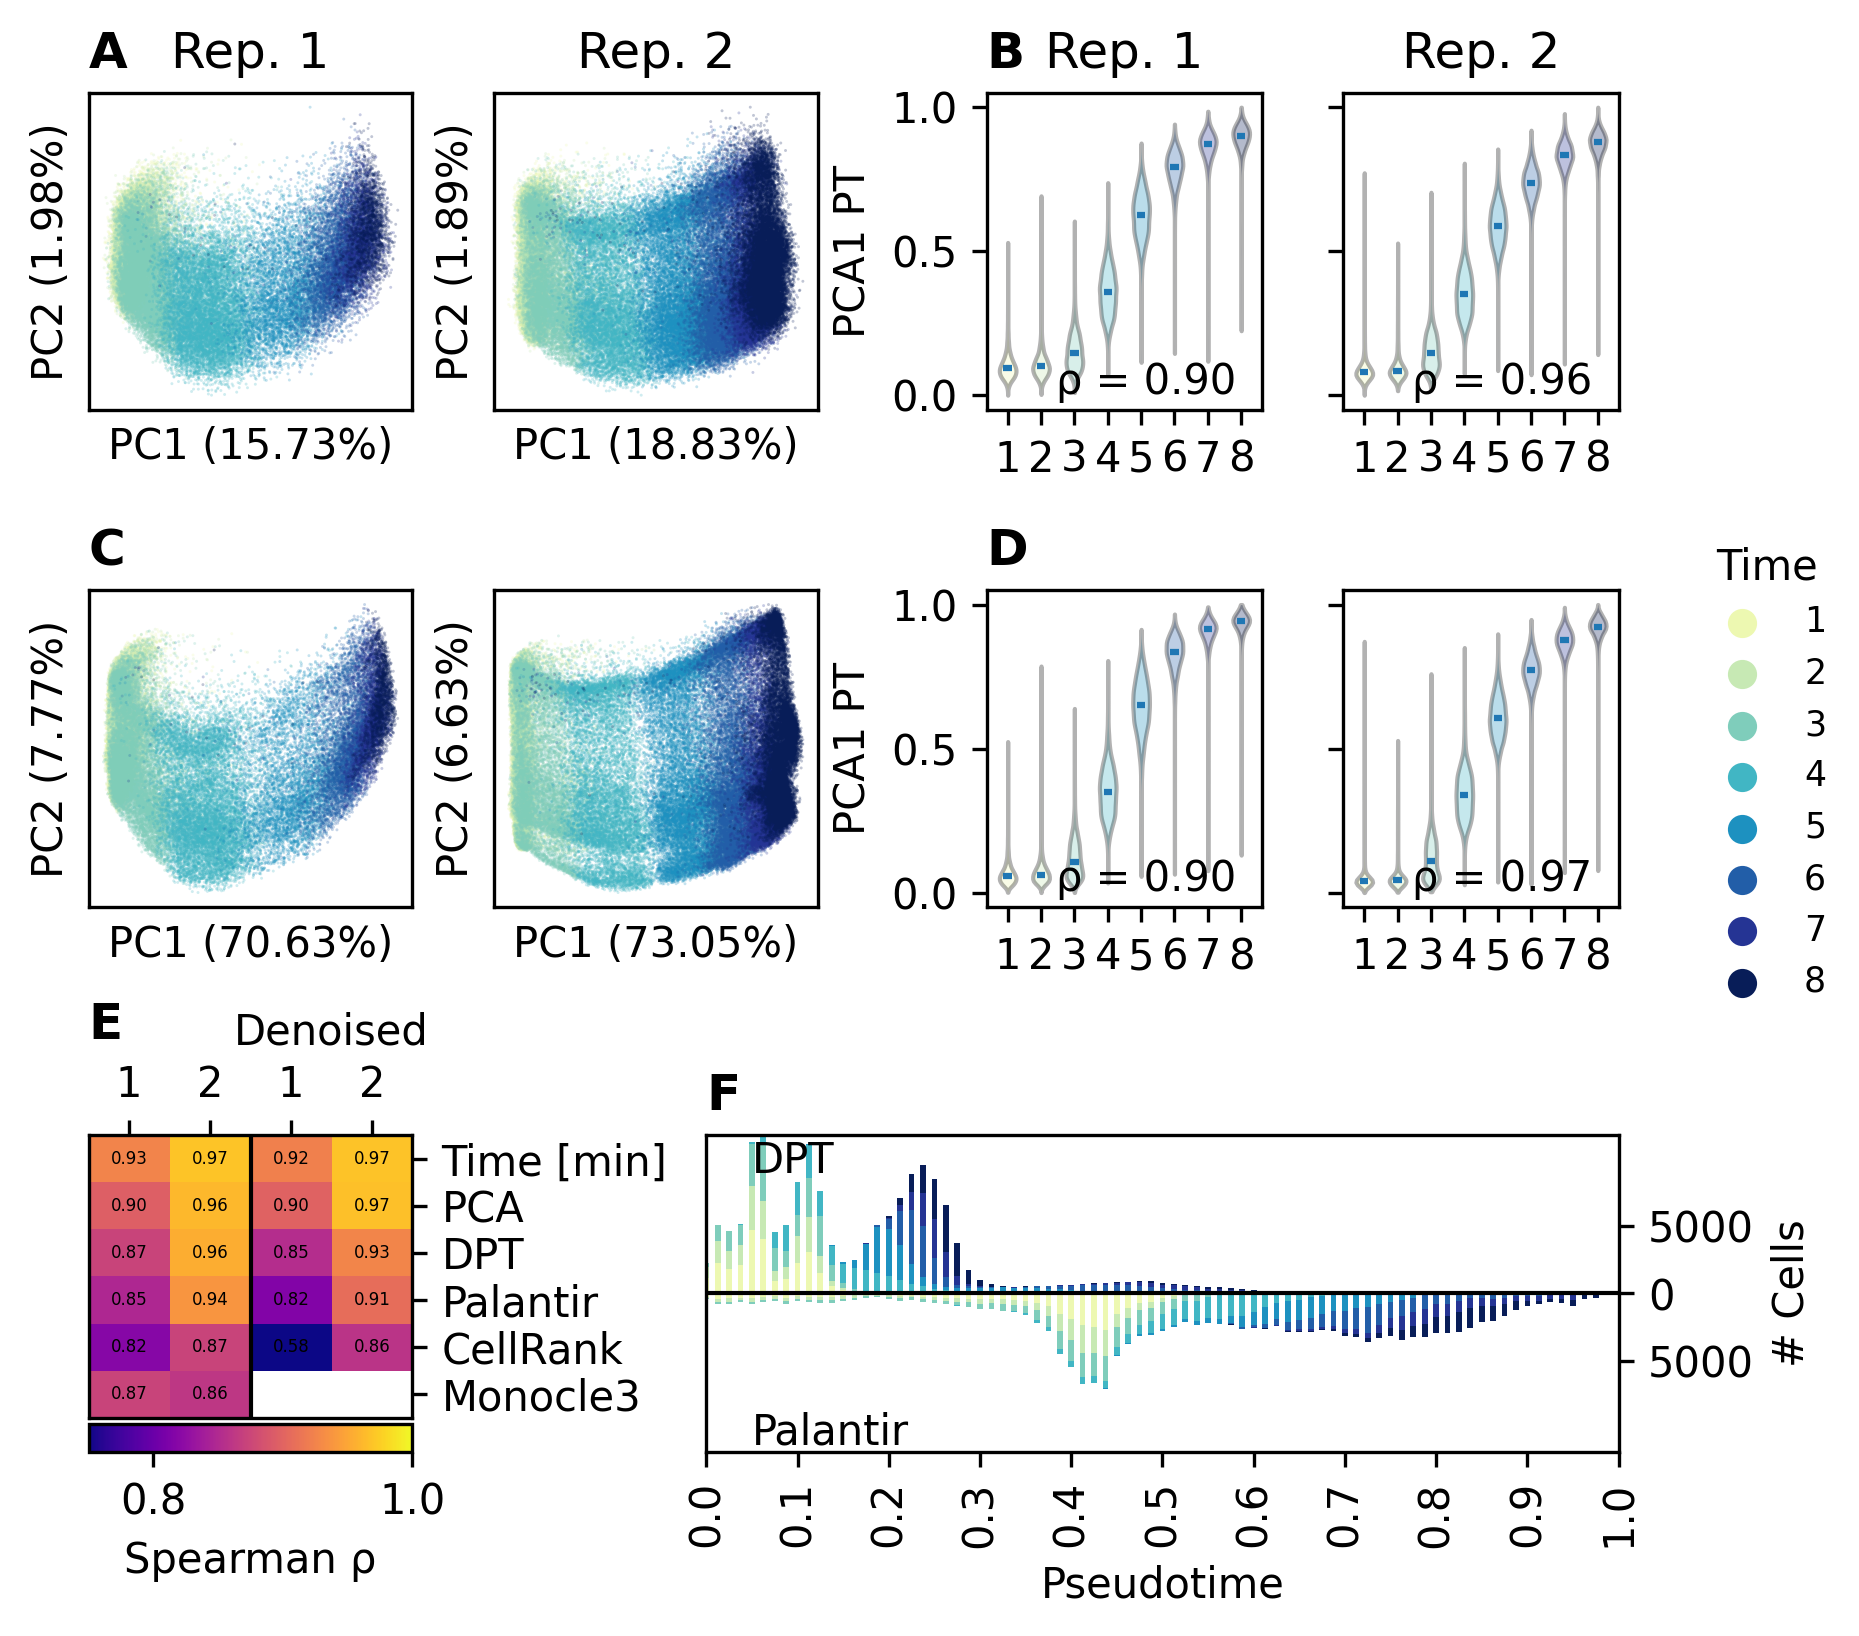

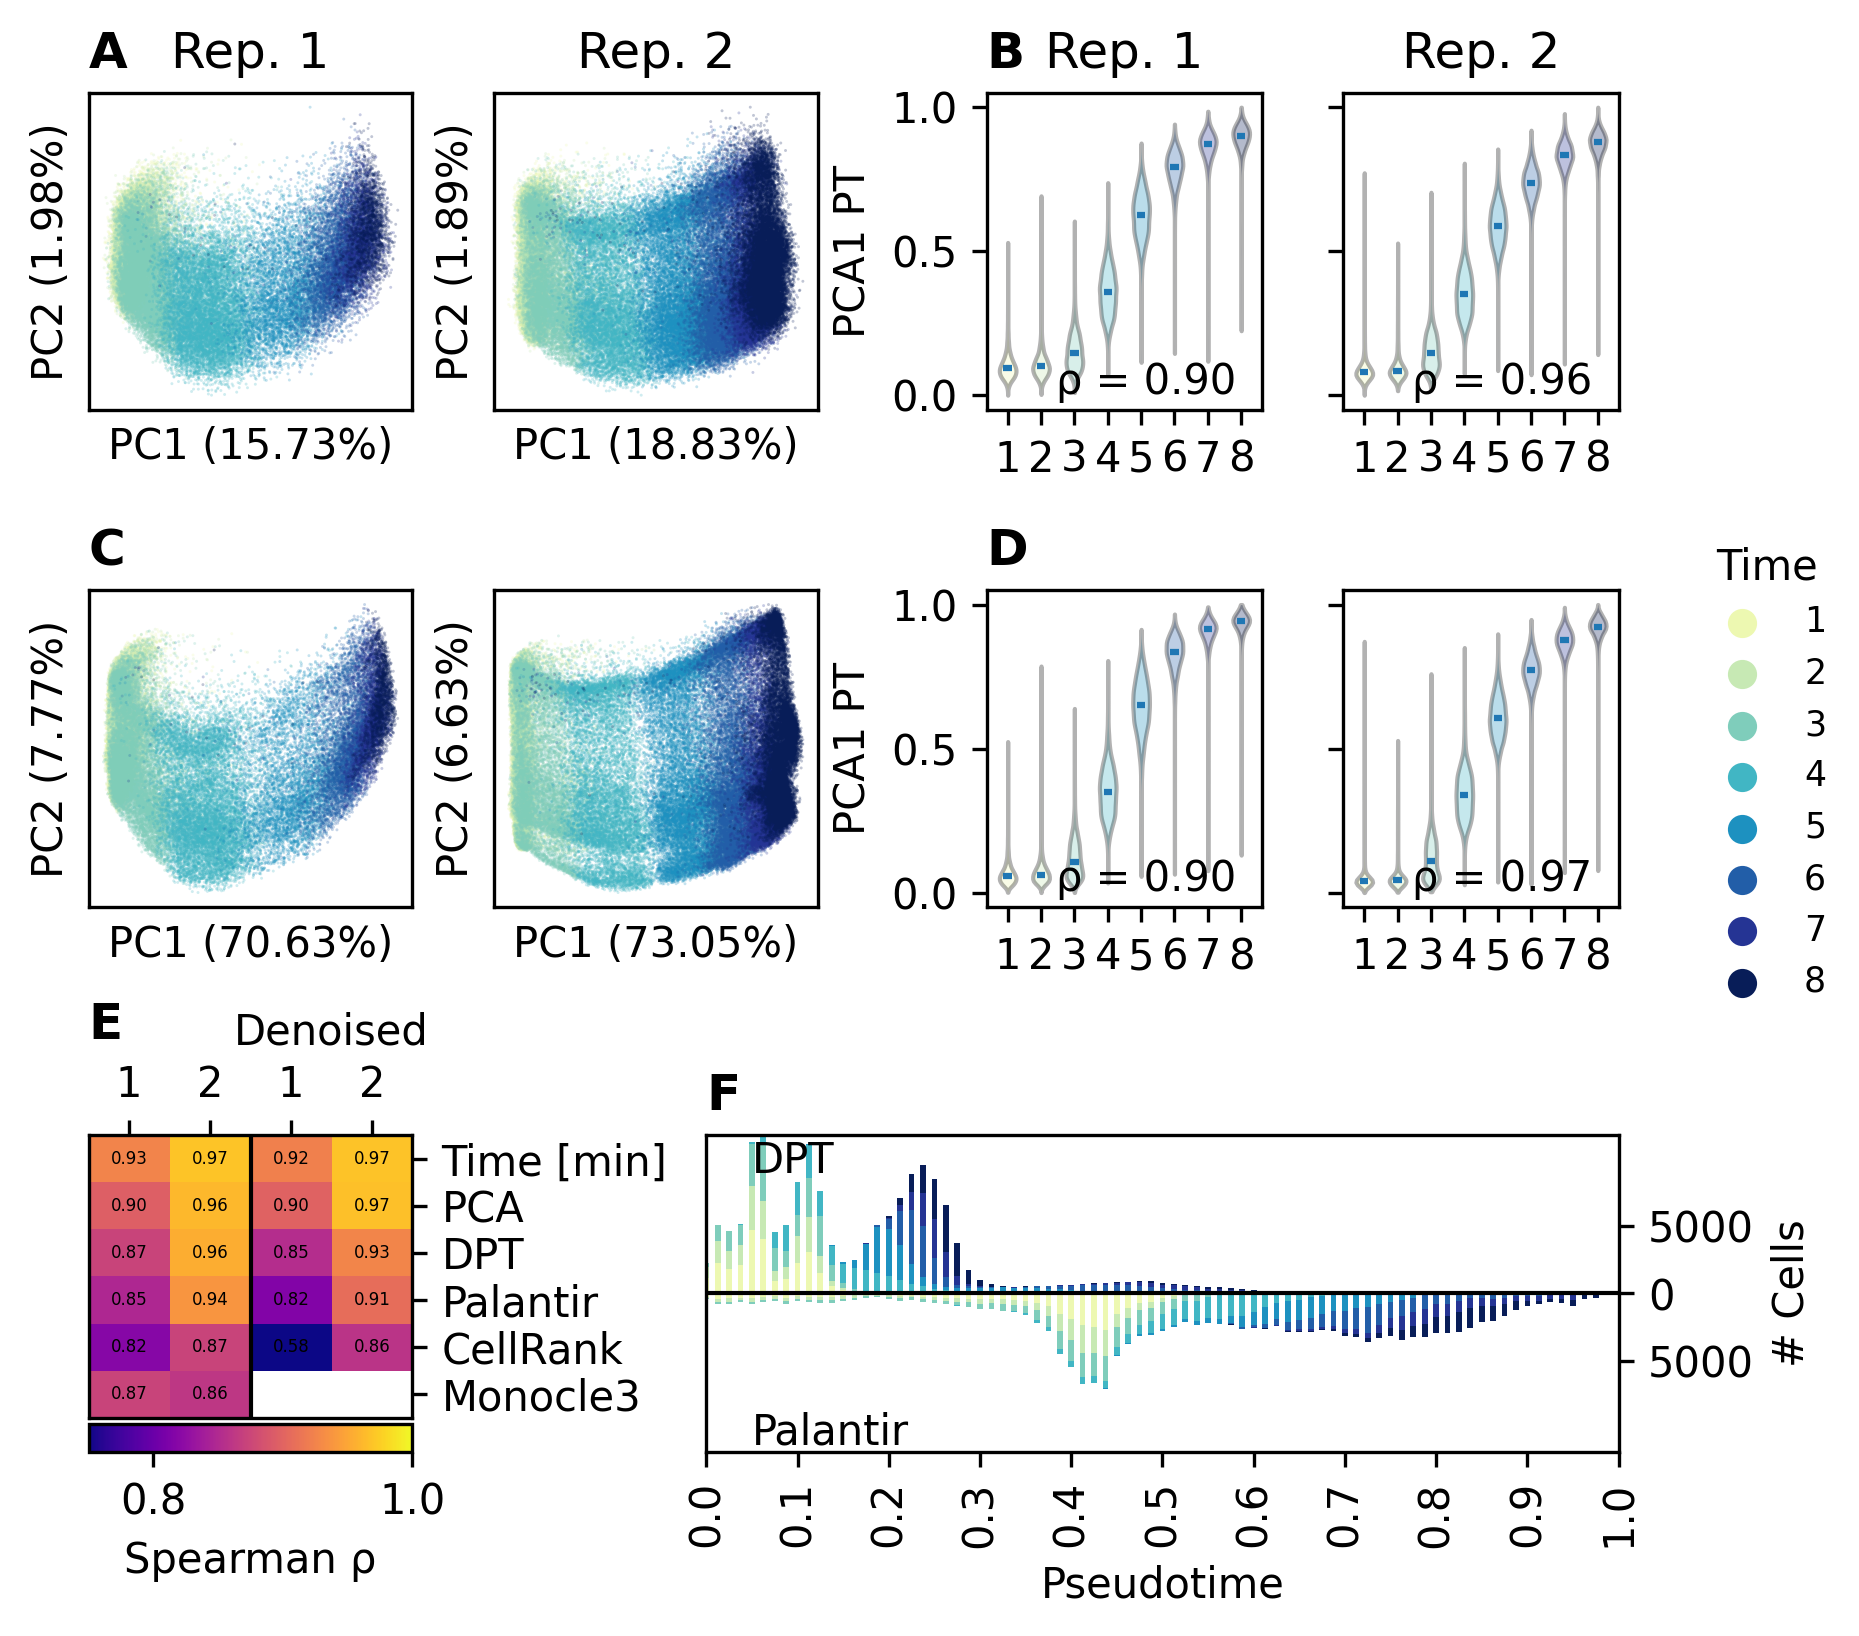

In [5]:
figure_3_plot(data)

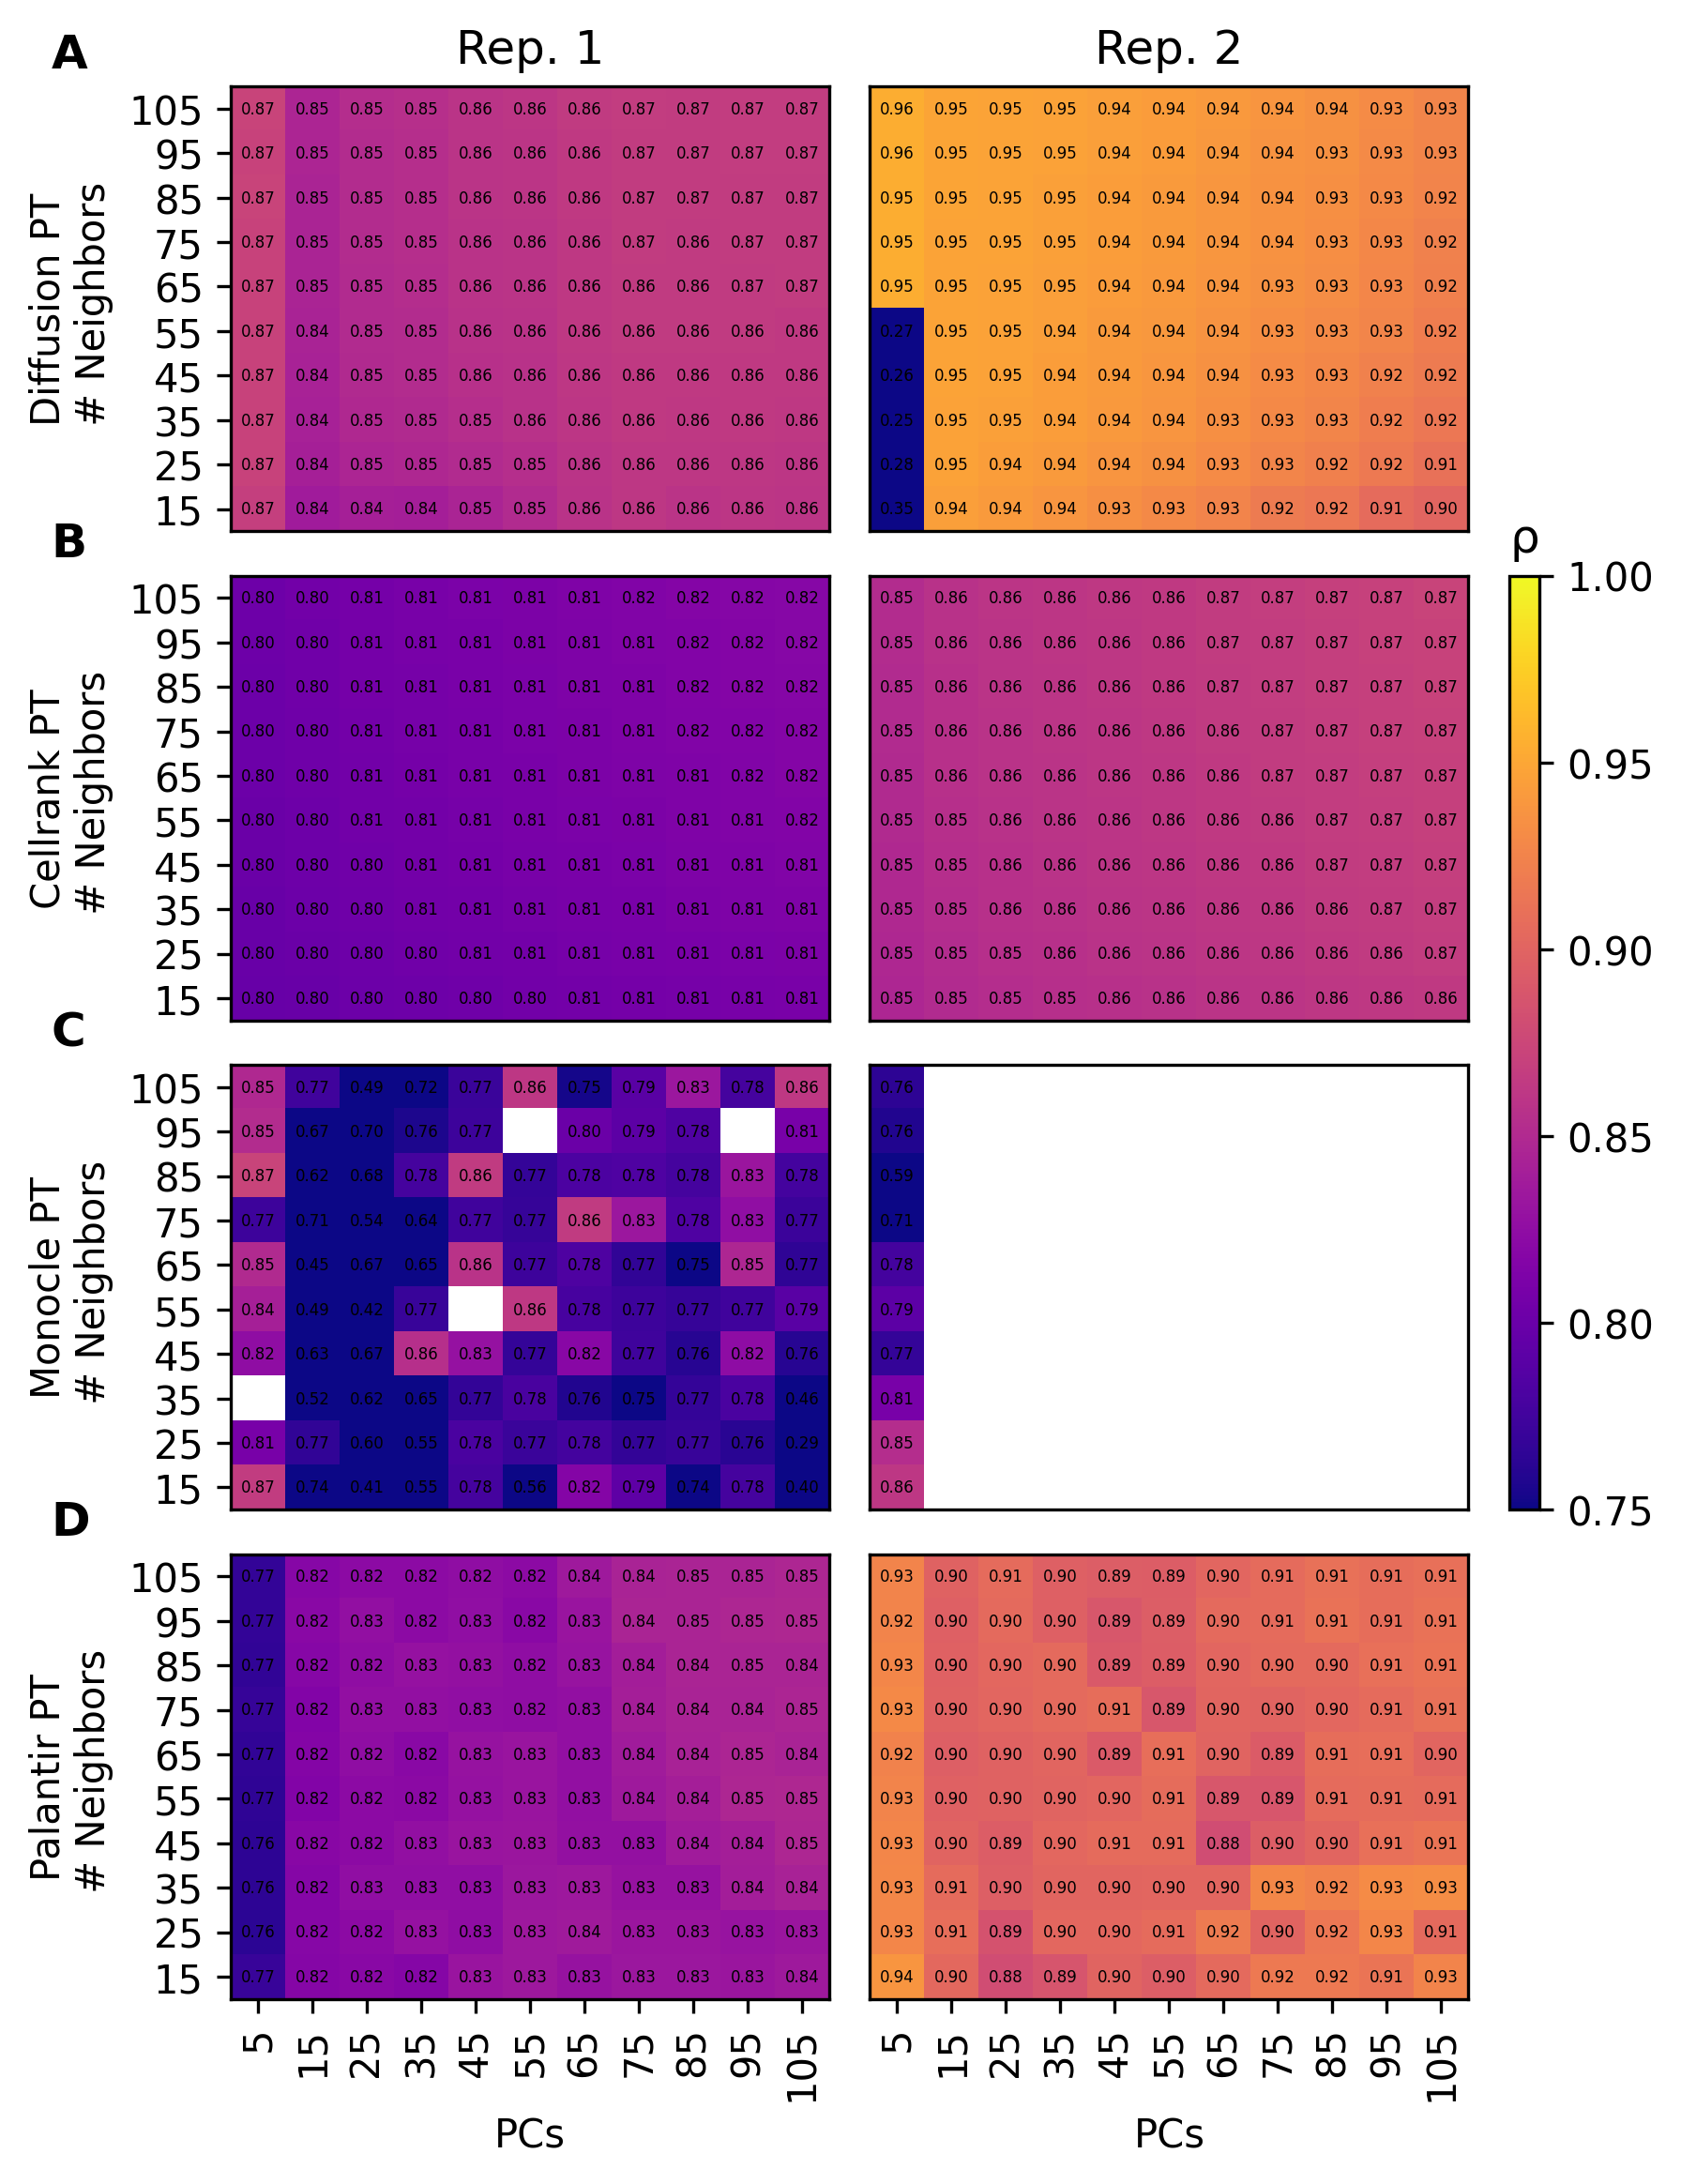

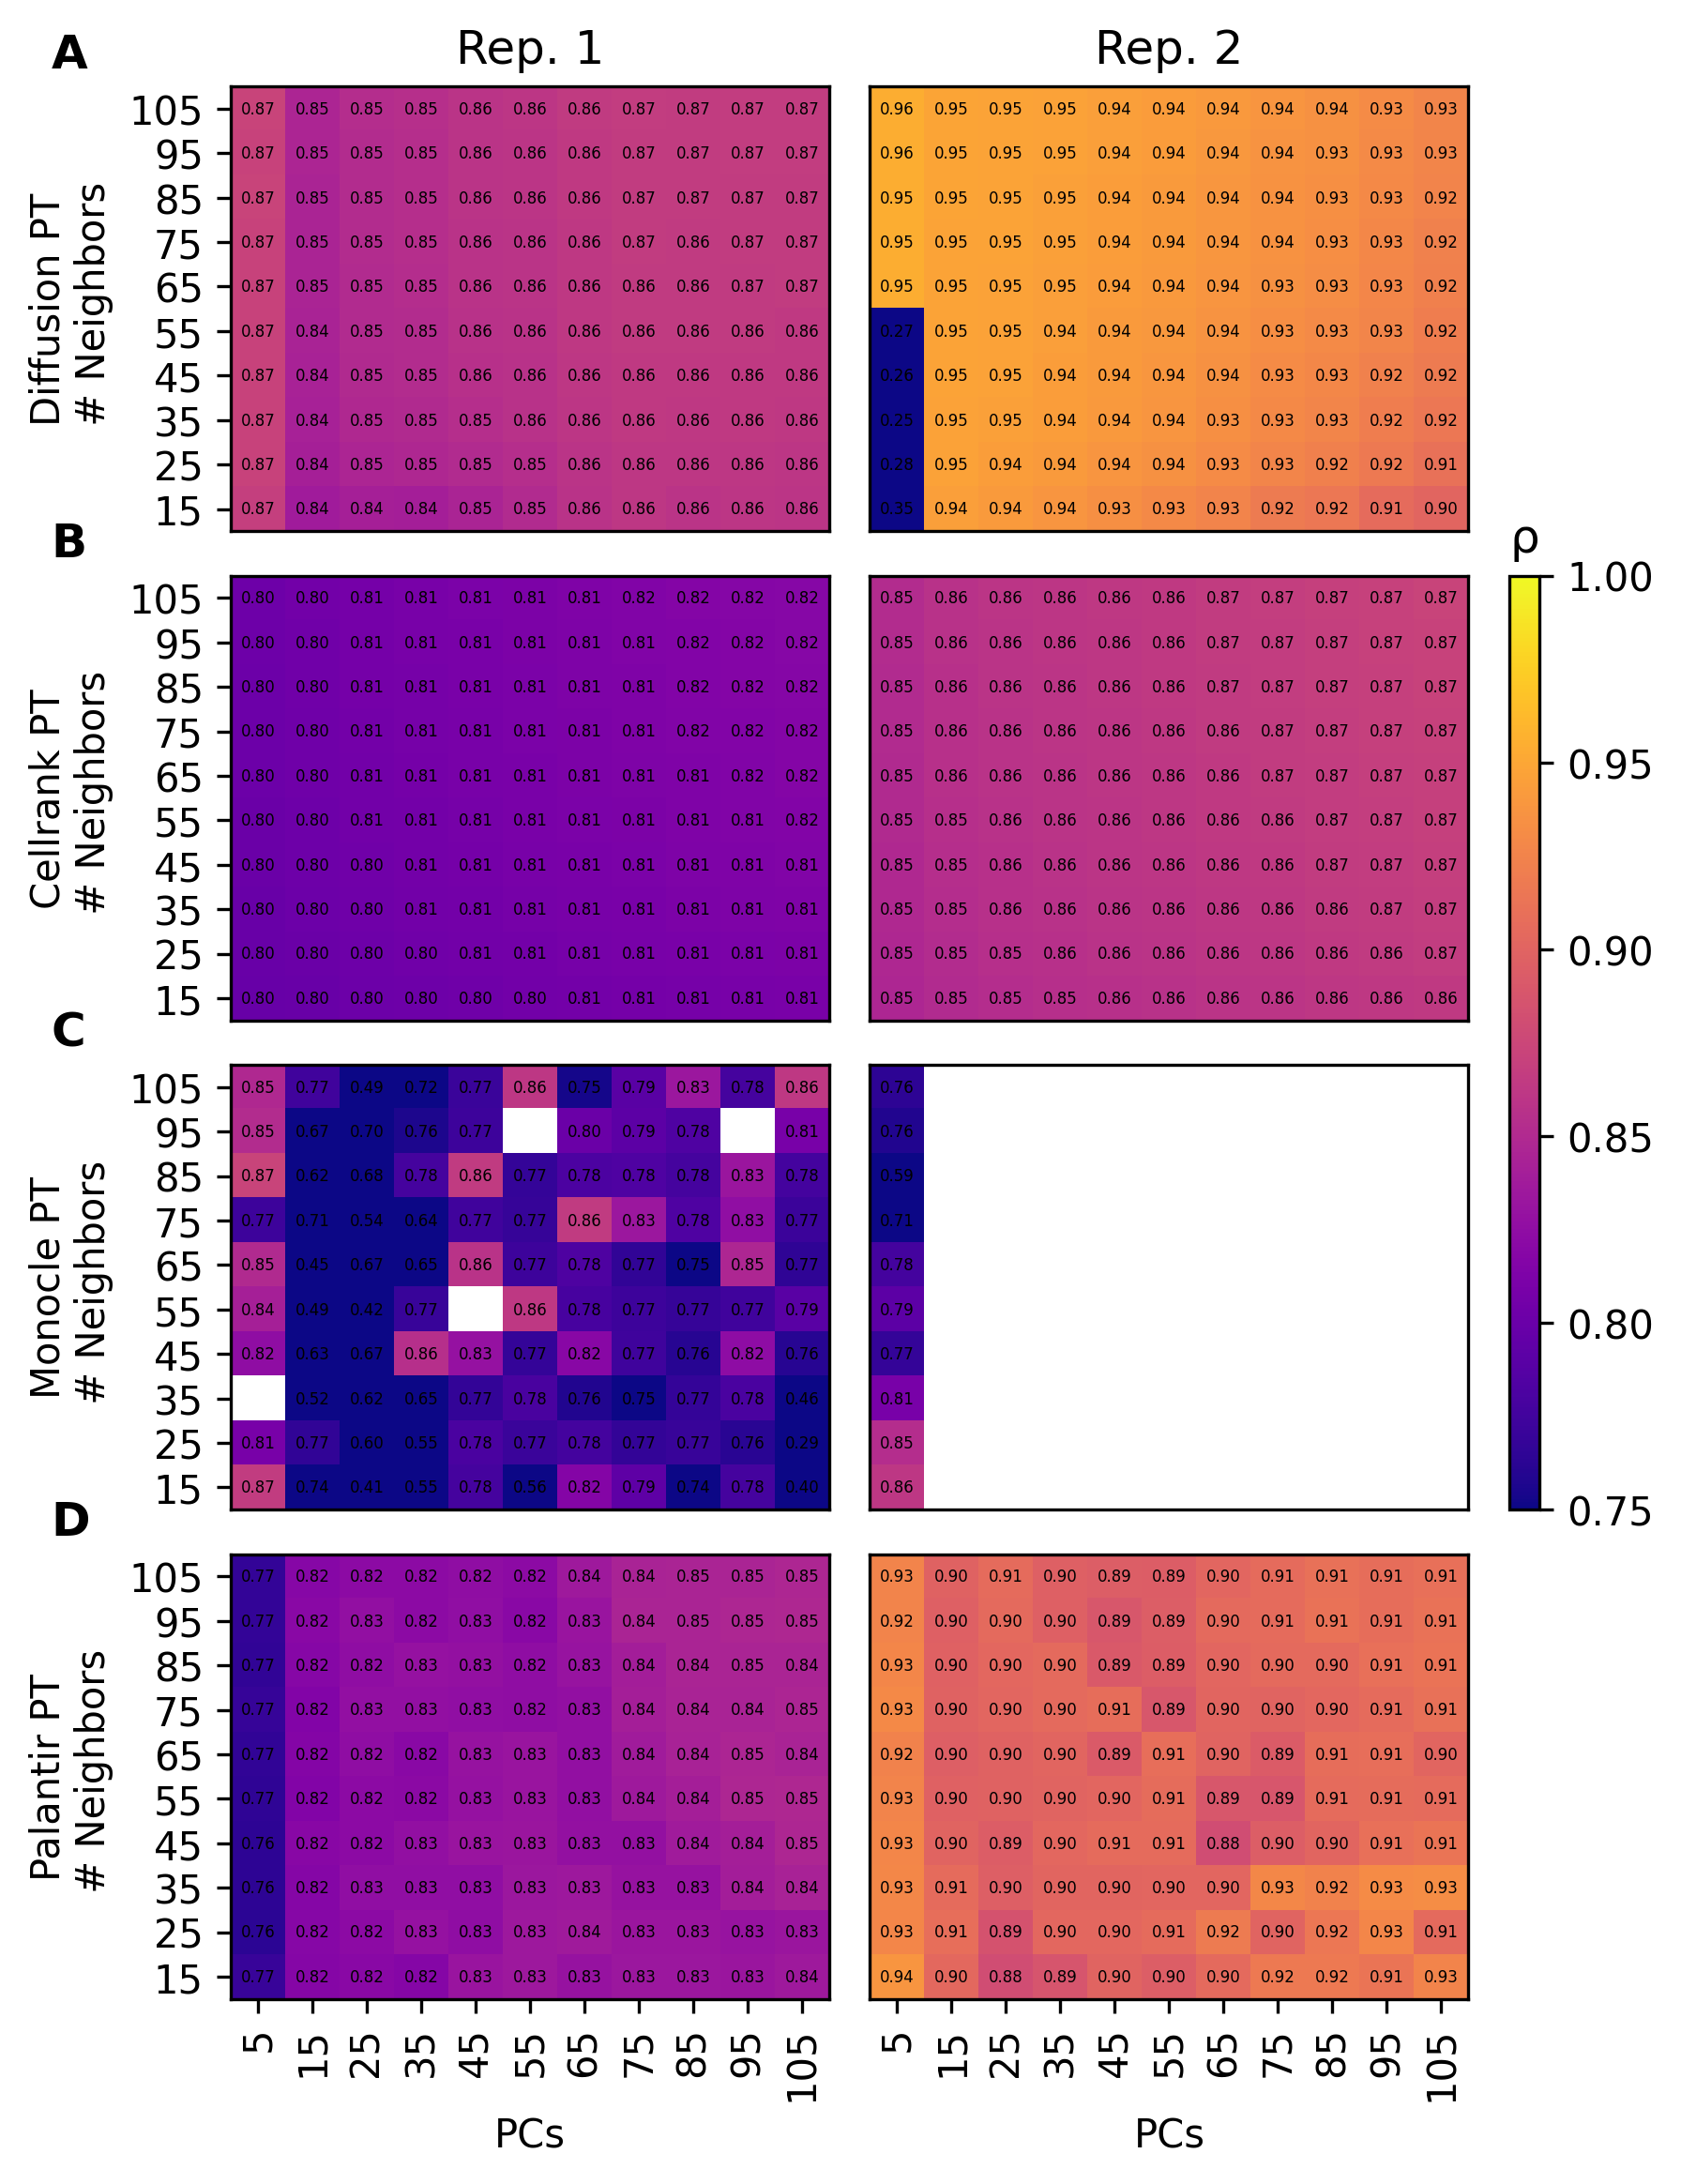

In [6]:
figure_3_supplement_1_plot(data)